# <center><b>  ISM 6562 Big Data for Business</b> </center>

### <center>  AIRLINE PERFORMANCE DATASET</center>

<center>by: Chukwuebuka Ezema  and Shruti Sridharan</center>
<br>
<br>
<br>

### <b>INTRODUCTION</b>
The U.S. Department of Transportation (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights. This data anlytics project aims to analyze the on-time flight departure performance and cancellations by major air carriers from Jan.2019 to Feb 2018
The data was downloaded from the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS):https://www.transtats.bts.gov/DL_SelectFields.asp <br>
<br>

#### <b>Exploratory Analysis:</b>
<b>Question 1</b><br>
Carrier with most flight cancellations.<br> 

<b>Question 2</b><br>
Consequently, which month and day of the week were flight cancellations most frequent?<br>

<b>Question 3</b><br>
What was the average delay time for flights origiating from Tampa (TPA)

<b>Question 4</b><br>
Which orgin city had the most delay?

<b>Research Question 5</b><br>
Origin city to Destination delay analysis

<b>Research Question 6</b><br>
Model


## <center>  EXPLORATORY ANALYSIS </center>

In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql import SQLContext
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as func
from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.sql.warehouse.dir", "file:///C:/temp").appName("SparkSQL").getOrCreate()

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sqlContext = SQLContext(sc)
sc

<SparkContext master=local[*] appName=SparkSQL>

In [170]:
# Load the data stored in csv format as a DataFrame.
data = spark.read.load(r'C:\Users\coe\Desktop\BigData\airline.csv',
                     format="csv", sep=",", inferSchema='true', header="true")

In [171]:
#create a new copy of the Spark dataframe
dfa = data

In [5]:
#Create Table for explatory analysis

data.createOrReplaceTempView("Airline")

In [6]:
#Total number of flights that took off in January (Not cancelled)
dfr1 = spark.sql("SELECT MKT_UNIQUE_CARRIER,CANCELLED from Airline where CANCELLED =0")

dfr1.count()

1891837

In [7]:
#Total number of flights cancelled in January

dfr1b = spark.sql("SELECT MKT_UNIQUE_CARRIER,CANCELLED from Airline where CANCELLED =1")

dfr1b.count()

35122

In [8]:
# % of flights cancelled

(dfr1b.count()/dfr1.count())*100

1.8565024365206941

In [9]:
#Carrier with most cancellations during Nov 2018 -  January 2019 period

dfr1b.groupby('MKT_UNIQUE_CARRIER').sum('CANCELLED').orderBy('sum(CANCELLED)', ascending=False).show()

+------------------+--------------+
|MKT_UNIQUE_CARRIER|sum(CANCELLED)|
+------------------+--------------+
|                AA|       12814.0|
|                UA|       10021.0|
|                WN|        5818.0|
|                DL|        2559.0|
|                AS|        1783.0|
|                B6|        1208.0|
|                F9|         334.0|
|                NK|         327.0|
|                G4|         142.0|
|                HA|         116.0|
+------------------+--------------+



In [10]:
# Weekday with most cancellations

dfr2 = spark.sql("SELECT DAY_OF_WEEK, CANCELLED from Airline where CANCELLED =1")

t = {1:"Monday", 2: "Tuesday", 3:"Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}

conv = udf(lambda x: t[x], StringType())
dfwd= dfr2.withColumn("Weekday", conv("DAY_OF_WEEK")).groupBy('Weekday').sum('CANCELLED').orderBy('sum(CANCELLED)', ascending=False).show()

+---------+--------------+
|  Weekday|sum(CANCELLED)|
+---------+--------------+
|   Sunday|        6638.0|
| Thursday|        6576.0|
|   Monday|        5882.0|
|Wednesday|        5248.0|
|  Tuesday|        4204.0|
| Saturday|        3459.0|
|   Friday|        3115.0|
+---------+--------------+



In [11]:
#Average delay of flights originating from Tampa, JFK, ORD, LAX

dfrd = spark.sql("SELECT ORIGIN, DEP_DELAY, CANCELLED from Airline where (ORIGIN='TPA' or ORIGIN='ORD' or ORIGIN='JFK' or ORIGIN='LAX') and CANCELLED=0")


dfrd.groupBy('ORIGIN').avg('DEP_DELAY').orderBy('avg(DEP_DELAY)', ascending= False).show()

In [13]:
# Origin city to Destination Delay
dfrod= spark.sql("SELECT concat(ORIGIN,'-' ,DEST) as Route, DEP_DEL15, DEP_DELAY, CANCELLED from Airline where CANCELLED=0")


#Display route with most delays and avg delay
dfrod.groupby('Route').agg({'DEP_DEL15': 'sum','DEP_DELAY': 'avg'}).orderBy('sum(DEP_DEL15)', ascending= False).show(10)

+-------+--------------+------------------+
|  Route|sum(DEP_DEL15)|    avg(DEP_DELAY)|
+-------+--------------+------------------+
|LAX-SFO|        1131.0|16.849896241641687|
|ORD-LGA|        1054.0|22.304322599361765|
|SFO-LAX|        1014.0|14.687845303867404|
|LGA-ORD|         830.0|20.165744247014274|
|SEA-SFO|         703.0| 19.19063136456212|
|SFO-SEA|         618.0| 17.84767393989296|
|MCO-EWR|         600.0|26.888107791446984|
|ATL-LGA|         590.0| 14.49507494646681|
|BOS-LGA|         590.0|17.653333333333332|
|LAS-SFO|         569.0| 17.59878726629611|
+-------+--------------+------------------+
only showing top 10 rows



In [14]:
# Origin State to Destination State route Delay
dfsd= spark.sql("SELECT concat(ORIGIN_STATE_NM,'-' ,DEST_STATE_NM) as Route, DEP_DELAY, DEP_DEL15 , CANCELLED from Airline where Cancelled=0")


# Display 
dfsd.groupby('Route').agg({'DEP_DEL15': 'sum','DEP_DELAY': 'avg'}).orderBy('sum(DEP_DEL15)', ascending= False).show(10, truncate=False)

+---------------------+--------------+------------------+
|Route                |sum(DEP_DEL15)|avg(DEP_DELAY)    |
+---------------------+--------------+------------------+
|California-California|12979.0       |10.397778512595442|
|Texas-Texas          |7846.0        |7.04169676953246  |
|Florida-New York     |3985.0        |15.34417568427753 |
|New York-Florida     |3347.0        |12.900401452877079|
|Texas-California     |3335.0        |9.647412619155697 |
|California-Texas     |2837.0        |7.827079193868862 |
|Nevada-California    |2822.0        |9.899078216076996 |
|Georgia-Florida      |2609.0        |7.272832369942196 |
|Arizona-California   |2534.0        |8.5738548273432   |
|Florida-New Jersey   |2524.0        |23.343812127236582|
+---------------------+--------------+------------------+
only showing top 10 rows



## <center><b>PREDICTION MODELING</b></center>

### K_MEANS CLUSTERING

In [175]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd

#copy dataframe
dataset = dfa

In [ ]:
#Remove cancelled flights
dataset = dataset.filter("CANCELLED = 0")

#Flights from Tampa
df_TPA = dataset.filter("Origin = 'TPA'")


In [187]:
# 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE', label= 'DEP_DEL15'

dataset= dataset.rdd.map(lambda x:(Vectors.dense([float(x[2]),float(x[9]),float(x[12]),float(x[17]),float(x[21])]),x[11]))
dataset= sqlContext.createDataFrame(dataset,["features","label"])
dataset.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[4.0,820.0,951.0,...|  0.0|
|[4.0,1658.0,1850....|  0.0|
|[4.0,1245.0,1623....|  0.0|
|[4.0,601.0,930.0,...|  0.0|
|[4.0,2025.0,13.0,...|  0.0|
|[4.0,1745.0,1925....|  0.0|
|[4.0,1539.0,1718....|  0.0|
|[4.0,2059.0,2238....|  1.0|
|[4.0,600.0,735.0,...|  0.0|
|[4.0,2059.0,2247....|  0.0|
|[4.0,1255.0,1428....|  1.0|
|[4.0,745.0,1008.0...|  0.0|
|[4.0,1331.0,1505....|  1.0|
|[4.0,1115.0,1259....|  0.0|
|[4.0,1610.0,1705....|  0.0|
|[4.0,1045.0,1246....|  1.0|
|[4.0,1410.0,1559....|  0.0|
|[4.0,1640.0,1854....|  0.0|
|[4.0,620.0,802.0,...|  0.0|
|[4.0,2010.0,2215....|  0.0|
+--------------------+-----+
only showing top 20 rows



In [188]:
# Trains a k-means model.
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(dataset)

In [189]:
# Make predictions
predictions = model.transform(dataset)

In [190]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6357182873415711


In [194]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[   3.94107326  906.86638784 1098.00522768  116.9379374   577.09201514]
[   3.97168075 1732.24330896 1922.53409441  115.07701396  574.34404913]
[   3.99435185 1226.45990707 1655.7066544   274.26100005 1869.99166419]
[   4.0742433  2175.20419402  272.39557852  217.20295696 1563.81440172]


###### KMEANS <br> using code found on https://datascience.stackexchange.com/questions/16700/confused-about-how-to-apply-kmeans-on-my-a-dataset-with-features-extracted

In [200]:
from scipy import stats
from sklearn.cluster import KMeans
import pandas as pd

#copy dataframe
df_tr = dfa
df_tr= df_tr.toPandas()

In [201]:
#Remove empty cancelled flights
df_tr=df_tr.loc[df_tr['CANCELLED'] == 0]

#Flights from Tampa
df_TPA=df_tr.loc[df_tr['ORIGIN'] == 'TPA']

In [202]:
df_TPA.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,CRS_DEP_TIME,...,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,_c27
4251,1,12,6,AS,523,TPA,Florida,SEA,Washington,1705,...,345.0,319.0,1.0,2520.0,NaN,NaN,NaN,NaN,NaN,None
4854,1,13,7,AS,523,TPA,Florida,SEA,Washington,1705,...,359.0,333.0,1.0,2520.0,NaN,NaN,NaN,NaN,NaN,None
5524,1,14,1,AS,523,TPA,Florida,SEA,Washington,1705,...,357.0,332.0,1.0,2520.0,NaN,NaN,NaN,NaN,NaN,None
6193,1,15,2,AS,523,TPA,Florida,SEA,Washington,1705,...,380.0,356.0,1.0,2520.0,NaN,NaN,NaN,NaN,NaN,None
6843,1,16,3,AS,523,TPA,Florida,SEA,Washington,1705,...,374.0,357.0,1.0,2520.0,NaN,NaN,NaN,NaN,NaN,None


In [203]:
#Standardize columns for predictions
clmns = ['DAY_OF_WEEK', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DEP_DELAY','DEP_DELAY','DEP_DEL15']
df_tr_std = stats.zscore(df_TPA[clmns])
print(df_tr_std)

[[ 0.99918605  0.85682409  1.11546914 ...  3.86347297 -0.3800056
  -0.48745897]
 [ 1.50218588  0.85682409  1.11546914 ...  3.86347297 -0.45183563
  -0.48745897]
 [-1.51581314  0.85682409  1.11546914 ...  3.86347297 -0.49972232
  -0.48745897]
 ...
 [ 0.99918605 -0.32904708 -0.36898519 ... -0.27630113 -0.40394894
  -0.48745897]
 [ 0.99918605 -0.32904708 -0.36898519 ... -0.27630113 -0.3800056
  -0.48745897]
 [ 0.99918605 -0.32904708 -0.36898519 ... -0.27630113 -0.06874211
  -0.48745897]]


In [ ]:
#Cluster the data
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_tr_std)
labels = kmeans.labels_

#Glue back to originaal data
df_TPA['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

In [205]:
#Lets analyze the clusters
print(df_TPA[clmns].groupby(['clusters']).mean())

          DAY_OF_WEEK  CRS_DEP_TIME  CRS_ARR_TIME  CRS_ELAPSED_TIME  \
clusters                                                              
0            4.023212   1155.741531   1392.138645        295.707026   
1            3.946885    915.208559   1084.253115        134.912398   
2            4.025211   1701.900384   1907.235511        140.145273   
3            4.138107   1533.483944   1706.805911        144.899119   

             DISTANCE  DEP_DELAY  DEP_DEL15  
clusters                                     
0         1903.638018   2.763488   0.112296  
1          786.110258  -2.689994   0.007300  
2          818.837048  -1.827978   0.000000  
3          867.368286  63.076158   1.000000  


In [206]:
import matplotlib.pyplot as plt
import seaborn as sns

(0, 2658.3827327604176)

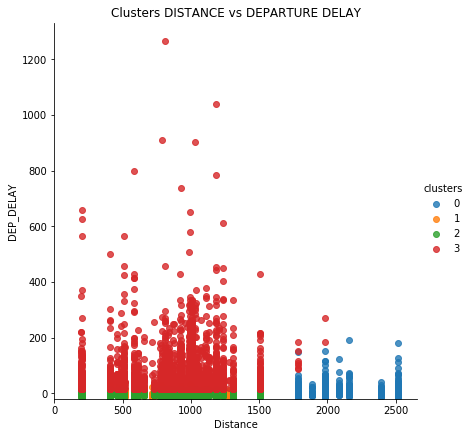

In [267]:
#Scatter plot of Departure delay and Distance for Flights leaving from Tampa airport
sns.lmplot('DISTANCE', 'DEP_DELAY', 
           data=df_TPA, 
           fit_reg=False, 
           hue='clusters', height = 6)
plt.title('Clusters DISTANCE vs DEPARTURE DELAY')
plt.xlabel('Distance')
plt.ylabel('DEP_DELAY')

plt.ylim(-20, None)
plt.xlim(0, None)


### <b>DECISION TREE CLASSIFIER MODEL</b>

Code used can be found on https://spark.apache.org/docs/latest/ml-guide.html

In [54]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

In [55]:
#parse columns for classification(datac) reason for cancellation & Regression(datar) for cancelled flights

datar = data.rdd.map(lambda x: ((x[14]), Vectors.dense(float(x[2]),float(x[4]),float(x[9]),float(x[12]),float(x[21]))))
datac = data.rdd.map(lambda x: ((x[15]), Vectors.dense(float(x[2]),float(x[4]),float(x[9]),float(x[12]),float(x[21]))))

In [56]:
# create dataframe for classification(datap) & Regression(datapr)

datap = sqlContext.createDataFrame(datac, ['label','features'],samplingRatio=0.2)
datapr = sqlContext.createDataFrame(datar, ['label','features'],samplingRatio=0.2)

In [57]:
datap

DataFrame[label: string, features: vector]

In [58]:
#Filter out null values

dfapp1=datap.filter("label is not null")
dfapp2=datapr.filter("label is not null")

In [59]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel", handleInvalid="skip").fit(dfapp1)

In [60]:
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dfapp1)

In [61]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dfapp1.randomSplit([0.7, 0.3])

In [62]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

In [63]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

In [64]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [65]:
# Make predictions.
predictions = model.transform(testData)

In [66]:
# Select example rows to display.
predictions.select("prediction", "indexedLabel", "label").show(10)

+----------+------------+-----+
|prediction|indexedLabel|label|
+----------+------------+-----+
|       0.0|         2.0|    A|
|       0.0|         2.0|    A|
|       0.0|         2.0|    A|
|       0.0|         2.0|    A|
|       0.0|         2.0|    A|
|       0.0|         2.0|    A|
|       0.0|         2.0|    A|
|       0.0|         2.0|    A|
|       0.0|         2.0|    A|
|       0.0|         2.0|    A|
+----------+------------+-----+
only showing top 10 rows



In [67]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.313273 


In [68]:
treeModel = model.stages[2]

In [69]:
# summary only
print(treeModel)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_e46396361599) of depth 5 with 17 nodes


## RANDOM FOREST Classification

In [100]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

In [101]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [102]:
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [103]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [104]:
# Make predictions.
predictions = model.transform(testData)

In [105]:
# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             B|    A|[1.0,36.0,1500.0,...|
|             B|    A|[1.0,37.0,1530.0,...|
|             B|    A|[1.0,41.0,1630.0,...|
|             B|    A|[1.0,124.0,1745.0...|
|             B|    A|[1.0,142.0,2030.0...|
+--------------+-----+--------------------+
only showing top 5 rows



In [106]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.315573


In [107]:
rfModel = model.stages[2]
print(rfModel)  # summary only

RandomForestClassificationModel (uid=RandomForestClassifier_ab48084be71c) with 10 trees


## RANDOM FOREST Regression

In [108]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


In [109]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4,handleInvalid='skip').fit(dfapp2)

In [110]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dfapp2.randomSplit([0.7, 0.3])

In [111]:
# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="indexedFeatures")

In [112]:
# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

In [113]:
# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

In [114]:
# Make predictions.
predictions = model.transform(testData)

In [115]:
# Select example rows to display.
predictions.select("prediction", "features", "label").show(5)

+--------------------+--------------------+-----+
|          prediction|            features|label|
+--------------------+--------------------+-----+
|0.019816210663356395|[1.0,1.0,700.0,81...|  0.0|
|0.004842800039435017|[1.0,1.0,700.0,11...|  0.0|
|0.019113037050858046|[1.0,1.0,845.0,95...|  0.0|
|0.005167497678158669|[1.0,2.0,1400.0,2...|  0.0|
|0.005167497678158669|[1.0,2.0,1400.0,2...|  0.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [116]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.133759


In [117]:
rfModel = model.stages[1]
print(rfModel)  # summary only

RandomForestRegressionModel (uid=RandomForestRegressor_27c53718ee78) with 20 trees


## GRADIENT BOOSTED-TREE (Regression)

In [118]:
from pyspark.ml.regression import GBTRegressor

In [119]:
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dfapp2)

In [120]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dfapp2.randomSplit([0.7, 0.3])

In [121]:
# Train a GBT model.
gbt = GBTRegressor(featuresCol="indexedFeatures", maxIter=10)

In [122]:
# Chain indexer and GBT in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, gbt])

In [123]:
# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

In [124]:
# Make predictions.
predictions = model.transform(testData)

In [125]:
# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

+--------------------+-----+--------------------+
|          prediction|label|            features|
+--------------------+-----+--------------------+
| 0.02011533181289338|  0.0|[1.0,1.0,700.0,81...|
| 0.02011533181289338|  0.0|[1.0,1.0,700.0,81...|
|0.005449802528100375|  0.0|[1.0,1.0,700.0,11...|
|0.002824482677950955|  0.0|[1.0,1.0,800.0,11...|
|0.002824482677950955|  0.0|[1.0,1.0,800.0,11...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [126]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.133617


In [127]:
gbtModel = model.stages[1]
print(gbtModel)  # summary only

GBTRegressionModel (uid=GBTRegressor_eeb37bef3270) with 10 trees
